#### Setup

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf

#### Load Data

In [28]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
data = [train, test]

#### Clean Data

In [29]:
# Null Values
for df in data:
    mean_age = df['Age'].mean()
    df['Age'] = df['Age'].fillna(mean_age)
    df['Age'] = df['Age'].astype(int)
    mode_embarked = df['Embarked'].mode()[0]
    df['Embarked'] = df['Embarked'].fillna(mode_embarked)
    df['Embarked'] = df['Embarked'].astype(str)

#drop string columns
for df in data:
    df.drop(columns = ['Name', 'Ticket', 'Cabin'], inplace = True)

# Feature Engineering
for df in data:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 1
    df.loc[df['FamilySize'] > 1, 'IsAlone'] = 0
    df['Fare_per_person'] = df['Fare'] / df['FamilySize']

for df in data:
    print (df.head())



   PassengerId  Survived  Pclass     Sex  Age  SibSp  Parch     Fare Embarked  \
0            1         0       3    male   22      1      0   7.2500        S   
1            2         1       1  female   38      1      0  71.2833        C   
2            3         1       3  female   26      0      0   7.9250        S   
3            4         1       1  female   35      1      0  53.1000        S   
4            5         0       3    male   35      0      0   8.0500        S   

   FamilySize  IsAlone  Fare_per_person  
0           2        0          3.62500  
1           2        0         35.64165  
2           1        1          7.92500  
3           2        0         26.55000  
4           1        1          8.05000  
   PassengerId  Pclass     Sex  Age  SibSp  Parch     Fare Embarked  \
0          892       3    male   34      0      0   7.8292        Q   
1          893       3  female   47      1      0   7.0000        S   
2          894       2    male   62      0      

#### Data Preprocessing

In [30]:
cat_cols = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'FamilySize']
num_cols = ['Age', 'Fare']

def preprocess(df, cat_cols, num_cols):
    encoder = OneHotEncoder(sparse_output = False)
    scaler = StandardScaler()
    
    #encode columns
    encoded_cols = encoder.fit_transform(df[cat_cols])
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(cat_cols))
    df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
    
    #scale columns
    scaled_cols = scaler.fit_transform(df[num_cols])
    scaled_df = pd.DataFrame(scaled_cols, columns=num_cols)
    df[num_cols] = scaled_df
    
    #drop old columns
    df.drop(columns=cat_cols + num_cols, inplace=True)
    
    return df
    
test = preprocess(test, cat_cols, num_cols)
train = preprocess(train, cat_cols, num_cols)

#manually add missing column because I'm not sure how to do it automatically
train['Parch_9'] = 0
           


In [31]:
print(test.columns)
print(train.columns)
print(test.shape)
print(train.shape)

Index(['PassengerId', 'IsAlone', 'Fare_per_person', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'SibSp_0', 'SibSp_1', 'SibSp_2',
       'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1',
       'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Parch_9',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize_1',
       'FamilySize_2', 'FamilySize_3', 'FamilySize_4', 'FamilySize_5',
       'FamilySize_6', 'FamilySize_7', 'FamilySize_8', 'FamilySize_11'],
      dtype='object')
Index(['PassengerId', 'Survived', 'IsAlone', 'Fare_per_person', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'SibSp_0', 'SibSp_1',
       'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0',
       'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'FamilySize_1',
       'FamilySize_2', 'FamilySize_3', 'FamilySize_4', 'FamilySize_5',
       'FamilySize_6', 'FamilySi

In [35]:
from sklearn.model_selection import train_test_split
#create train test split
X = train.drop(columns = 'Survived')
y = train['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0) 


/Volumes/T7 Shield APFS/Non School Projects/Kaggle-Challenges/.venv/lib/python3.11/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<Axes: title={'center': 'Accuracy'}>

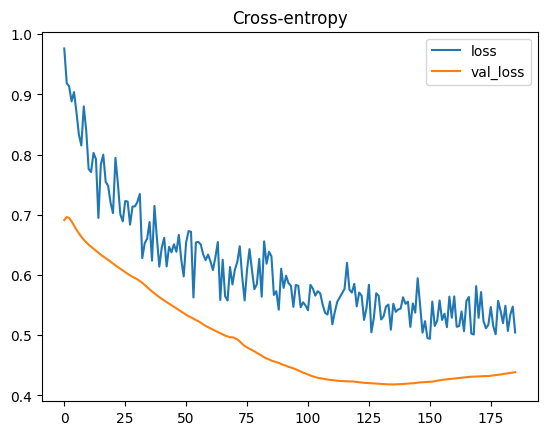

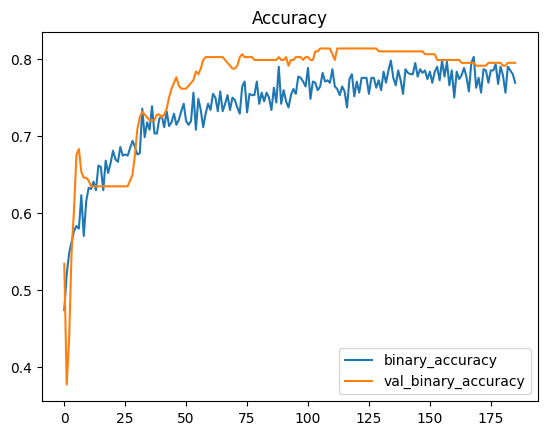

In [43]:

# Neural Network Processing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

input_shape = (35,) #bad to hardcode but here we are

model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(1024, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation = 'sigmoid'),
])
model.compile(optimizer = Adam(learning_rate = 0.00005), loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

#Early Stoppage
early_stopping = keras.callbacks.EarlyStopping(
    patience = 50,
    min_delta = 0.00001,
    restore_best_weights = True,
)

#learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience= 30,
    min_lr = 0.00001
)

history = model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size = 256,
    epochs = 1000,
    verbose = 0,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [44]:
# Make predictions on the test data
predictions = model.predict(test)

# Convert predictions to binary (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Convert predictions to DataFrame
predictions_df = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': binary_predictions.flatten()
})

# Save predictions to CSV
predictions_df.to_csv('predictions.csv', index=False)



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
